# Hybrid Recommendation System Experiments

This notebook experiments with a **weighted hybrid recommender** that combines an item-based collaborative filtering signal with a heuristic (e.g., popularity).
It uses the MovieLens 1M dataset and evaluates the model using **Precision@K** across different weighting parameters.
The goal is to see how blending collaborative and heuristic signals impacts recommendation quality and to illustrate when hybridisation can improve upon pure collaborative or heuristic approaches.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data loading and evaluation utilities from the project
from src.data_reading import read_ratings_file
from src.evaluation import temporal_split, evaluate_precision_at_k

# Hybrid recommender we implemented
from src.models.hybrid_recommender import weighted_hybrid_recommendation

## Data Preparation

We load the ratings data from the MovieLens 1M dataset using the project's helper functions.
The data contain user IDs, movie IDs, ratings (1–5), and timestamps (in Unix seconds).
To evaluate the recommender, we perform a temporal split: the earliest 90% of interactions are used for training, and the most recent 10% are held out for testing.

In [3]:
ratings = read_ratings_file()
ratings['timestamp'] = pd.to_datetime(ratings['timestamp']).astype('int64') // 10**9

train, test = temporal_split(ratings, test_ratio=0.1)

Train set size: (962251, 4)
Test set size: (37958, 4)
Train timeframe: 1970-01-01 00:00:00 - 1970-01-01 00:00:00
Test timeframe: 1970-01-01 00:00:01 - 1970-01-01 00:00:01


## Hybrid Reccomendations

The testing objective is to determine, how different values of the parameter \alpha across different metrics influence the resulting Precision@K score.

In [4]:
np.random.seed(42)
unique_test_users = test.user_id.unique()
sample_size = min(100, len(unique_test_users))
sampled_users = np.random.choice(unique_test_users, size=sample_size, replace=False)

test_sample = test[test.user_id.isin(sampled_users)]

In [7]:
def compute_precision(alpha: float, heuristics: str = 'popularity') -> float:
    "Compute Precision@10 for a given alpha on the sampled users."
    recs_df = weighted_hybrid_recommendation(
        interactions=train,
        alpha=alpha,
        heuristics=heuristics,
        k=10,
        user_column='user_id',
        item_column='movie_id',
        rating_column='rating',
    )
    recs_df = recs_df[recs_df['user_id'].isin(sampled_users)]
    rec_dict = recs_df.groupby('user_id')['movie_id'].apply(list).to_dict()

    def recommend_k_hybrid(user_id: int, test: pd.DataFrame, k: int) -> np.ndarray:
        return rec_dict.get(user_id, [])[:k]

    return evaluate_precision_at_k(
        test=test_sample,
        recommend_k_fn=recommend_k_hybrid,
        k=10
    )

heuristics_list = ['popularity', 'recency', 'pagerank']
alpha_values = [0.0, 0.25, 0.5, 0.75, 1.0]

results = []
for heur in heuristics_list:
    for alpha in alpha_values:
        prec = compute_precision(alpha, heuristics=heur)
        results.append({
            'heuristic': heur,
            'alpha': alpha,
            'precision@10': prec,
        })
        print(f'heuristic={heur}, alpha={alpha}: Precision@10={prec:.4f}')

results_df = pd.DataFrame(results)
results_df

heuristic=popularity, alpha=0.0: Precision@10=0.0010
heuristic=popularity, alpha=0.25: Precision@10=0.1270
heuristic=popularity, alpha=0.5: Precision@10=0.1260
heuristic=popularity, alpha=0.75: Precision@10=0.1240
heuristic=popularity, alpha=1.0: Precision@10=0.1220
heuristic=recency, alpha=0.0: Precision@10=0.0010
heuristic=recency, alpha=0.25: Precision@10=0.0010
heuristic=recency, alpha=0.5: Precision@10=0.0010
heuristic=recency, alpha=0.75: Precision@10=0.0010
heuristic=recency, alpha=1.0: Precision@10=0.0030
heuristic=pagerank, alpha=0.0: Precision@10=0.0010
heuristic=pagerank, alpha=0.25: Precision@10=0.1310
heuristic=pagerank, alpha=0.5: Precision@10=0.1240
heuristic=pagerank, alpha=0.75: Precision@10=0.1270
heuristic=pagerank, alpha=1.0: Precision@10=0.1260


,heuristic,alpha,precision@10
0,popularity,0.00,0.001
1,popularity,0.25,0.127
2,popularity,0.50,0.126
3,popularity,0.75,0.124
4,popularity,1.00,0.122
5,recency,0.00,0.001
6,recency,0.25,0.001
7,recency,0.50,0.001
8,recency,0.75,0.001
9,recency,1.00,0.003


### Visualising the effect of the weight parameter



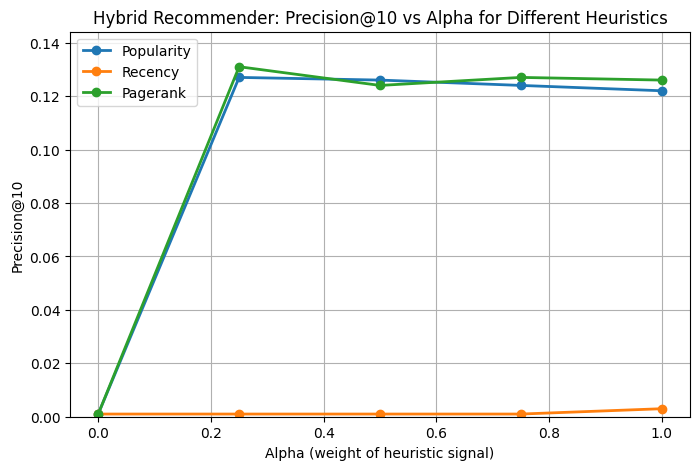

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for heur in heuristics_list:
    subset = results_df[results_df['heuristic'] == heur]
    plt.plot(
        subset['alpha'],
        subset['precision@10'],
        marker='o',
        linewidth=2,
        label=heur.title()
    )

plt.xlabel('Alpha (weight of heuristic signal)')
plt.ylabel('Precision@10')
plt.title('Hybrid Recommender: Precision@10 vs Alpha for Different Heuristics')
plt.ylim(0, results_df['precision@10'].max() * 1.1)
plt.grid(True)
plt.legend()
plt.show()